# Probabilistic Baseline – Logistic Regression

This notebook establishes the **probabilistic baseline model** for the Liga MX project using logistic regression.

The primary objective is **not** to maximize classification accuracy, but to obtain **stable, interpretable, and well-calibrated probability estimates** that can serve as a reliable reference point for all subsequent modeling efforts.

This baseline defines what “good behavior” looks like in probability space.

---

## 🎯 Objectives

- Build a transparent and interpretable probabilistic baseline
- Establish reference metrics (log loss, Brier score)
- Evaluate probability distributions and calibration behavior
- Serve as a benchmark for non-linear and higher-capacity models

All future improvements are evaluated **relative to this baseline**, not in isolation.

---

## 🧠 Modeling Rationale

Logistic regression is chosen because it:
- Produces directly interpretable probabilities
- Has low variance and strong stability properties
- Serves as a natural baseline for calibration analysis

In high-variance domains like football, a stable baseline is often more valuable than a complex model with unstable probabilities.

---

## 🔬 Feature Context

The model operates on **strictly pre-match features**, including:

- Team form
- Team momentum
- Relative differences between home and away teams

All features are constructed to respect temporal ordering and football logic.

---

## 📊 Evaluation Focus

Model evaluation prioritizes probabilistic quality over accuracy:

- Log loss
- Brier score
- Probability distribution analysis
- Reliability curves

Calibration quality is treated as a first-class objective.

---

## 🚧 Scope & Limitations

- Linear decision boundary
- No interaction terms
- No aggressive feature expansion

These limitations are intentional and define the baseline’s role as a **reference model**, not a final solution.

---

## 🔗 Role in the Project

This notebook anchors:
- Model comparison
- Calibration analysis
- Interpretation of probability zones

It provides the foundation upon which more expressive models are evaluated and justified.


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
import sys
from pathlib import Path

PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data"

In [ ]:
from src.features.build_features import build_prematch_dataset
df = build_prematch_dataset(DATA_DIR / "raw" / "2023mx1.csv", None)
df.info()

Index(['match_id', 'date', 'home_advantage', 'home_win', 'home_team',
       'away_team', 'home_form', 'away_form', 'form_diff', 'home_momentum',
       'away_momentum', 'momentum_diff'],
      dtype='object')

In [18]:
df['home_win'].value_counts(normalize=True)


home_win
0    0.529412
1    0.470588
Name: proportion, dtype: float64

In [19]:
features = [
    'home_form',
    'away_form',
    'home_momentum',
    'away_momentum'
]

df[features].describe()

,home_form,away_form,home_momentum,away_momentum
count,170.000000,170.000000,170.000000,1.700000e+02
mean,0.430980,0.411765,0.071765,-7.058824e-02
std,0.219514,0.212354,0.588974,5.893178e-01
min,0.000000,0.000000,-2.000000,-3.000000e+00
25%,0.266667,0.266667,-0.200000,-3.000000e-01
50%,0.466667,0.400000,0.000000,-1.264938e-16
75%,0.600000,0.533333,0.300000,2.000000e-01
max,1.000000,1.000000,3.000000,3.000000e+00


In [20]:
pd.qcut(df['form_diff'], q=4)
df.groupby(pd.qcut(df['form_diff'], q=4))['home_win'].mean()


C:\Users\USER\AppData\Local\Temp\ipykernel_6076\942101546.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['form_diff'], q=4))['home_win'].mean()


form_diff
(-0.801, -0.2]    0.130435
(-0.2, 0.0]       0.302326
(0.0, 0.2]        0.641026
(0.2, 0.667]      0.857143
Name: home_win, dtype: float64

C:\Users\USER\AppData\Local\Temp\ipykernel_6076\2951947421.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby(pd.qcut(df['form_diff'], q=4))['home_win'].mean().plot(kind='bar')


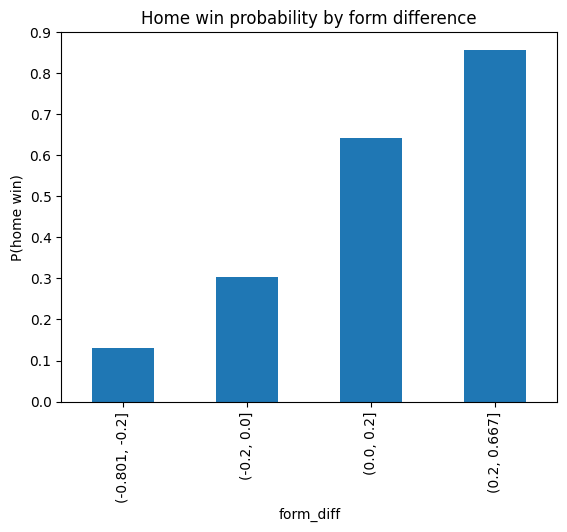

In [21]:
import matplotlib.pyplot as plt

df.groupby(pd.qcut(df['form_diff'], q=4))['home_win'].mean().plot(kind='bar')
plt.ylabel('P(home win)')
plt.title('Home win probability by form difference')
plt.show()

In [22]:
from sklearn.model_selection import train_test_split

features = [
    'home_form',
    'away_form',
    'home_momentum',
    'away_momentum'
]

X = df[features]
y = df['home_win']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [23]:
from sklearn.linear_model import LogisticRegression

log_raw = LogisticRegression(
    penalty=None,
    solver='lbfgs',
    max_iter=1000
)

log_raw.fit(X_train, y_train)
# Logistic without regularization

c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",None
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001
,"fit_intercept fit_intercept: bool, default=TrueSpecifies if a constant (a.k.a. bias or intercept) should beadded to the decision function.",True
,"intercept_scaling intercept_scaling: float, default=1Useful only when the solver `liblinear` is usedand `self.fit_intercept` is set to `True`. In this case, `x` becomes`[x, self.intercept_scaling]`,i.e. a ""synthetic"" feature with constant value equal to`intercept_scaling` is appended to the instance vector.The intercept becomes``intercept_scaling * synthetic_feature_weight``... note:: The synthetic feature weight is subject to L1 or L2 regularization as all other features. To lessen the effect of regularization on synthetic feature weight (and therefore on the intercept) `intercept_scaling` has to be increased.",1
,"class_weight class_weight: dict or 'balanced', default=NoneWeights associated with classes in the form ``{class_label: weight}``.If not given, all classes are supposed to have weight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.Note that these weights will be multiplied with sample_weight (passedthrough the fit method) if sample_weight is specified... versionadded:: 0.17 *class_weight='balanced'*",None
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle thedata. See :term:`Glossary ` for details.",None
,"solver solver: {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'}, default='lbfgs'Algorithm to use in the optimization problem. Default is 'lbfgs'.To choose a solver, you might want to consider the following aspects:- 'lbfgs' is a good default solver because it works reasonably well for a wide class of problems.- For :term:`multiclass`

In [24]:
from sklearn.metrics import accuracy_score, log_loss

y_pred = log_raw.predict(X_test)
y_proba = log_raw.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Log loss:", log_loss(y_test, y_proba))


Accuracy: 0.8837209302325582
Log loss: 0.2490895275644996


In [25]:
import pandas as pd

coef_df = pd.DataFrame({
    'feature': features,
    'coef': log_raw.coef_[0]
}).sort_values(by='coef', ascending=False)

coef_df


,feature,coef
0,home_form,13.324934
2,home_momentum,8.163105
3,away_momentum,-0.456989
1,away_form,-5.355450


In [26]:
log_l2 = LogisticRegression(
    penalty='l2',
    C=1.0,
    solver='lbfgs',
    max_iter=1000
)

log_l2.fit(X_train, y_train)

y_proba_l2 = log_l2.predict_proba(X_test)[:, 1]

print("Log loss L2:", log_loss(y_test, y_proba_l2))


Log loss L2: 0.3069844213891649


c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


In [27]:
from sklearn.calibration import CalibratedClassifierCV

cal_l2 = CalibratedClassifierCV(
    log_l2,
    method='isotonic',
    cv=5
)

cal_l2.fit(X_train, y_train)

y_proba_cal = cal_l2.predict_proba(X_test)[:, 1]
print("Log loss calibrated:", log_loss(y_test, y_proba_cal))


Log loss calibrated: 0.25188690300272415


c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\USER\Python\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'pen

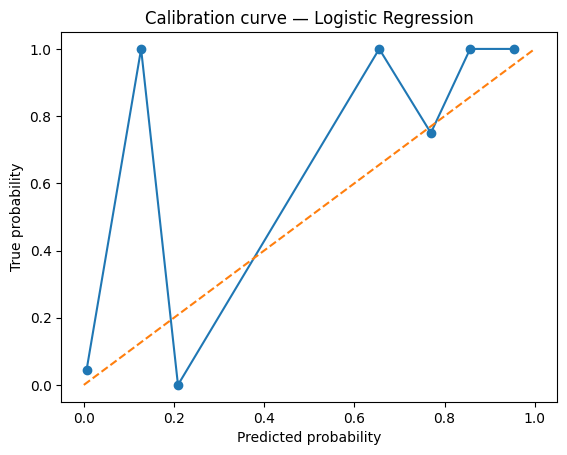

In [28]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_proba_cal, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('Predicted probability')
plt.ylabel('True probability')
plt.title('Calibration curve — Logistic Regression')
plt.show()
